<a href="https://colab.research.google.com/github/pachterlab/BI-BE-CS-183-2023/blob/main/HW3/Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 3 Problem 4**

In this problem you will compare PCA and SVD, common procedures for dimensionality reduction, on a single-cell dataset. Using the eigenvectors (components) of these factorization procedures we will see how relevant "directions" in biological data can be extracted, such as components which distinguish between the various cell types in the data.


##**Import data and install packages**

In [30]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn
from sklearn.decomposition import PCA

In [3]:
# ! allows you to run commands in the command line, as you would in your normal terminal/command line interface

In [4]:
#Download count matrix of cell by gene counts and metadata files, DOI: 10.22002/D1.2315
#tar.gz file which has:
#(1) count matrix 
#(2) metadata for cells (cell type, date of experimental run) 
#(3) metadata for genes (gene names)

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

download_file('10.22002/D1.2315','.gz')


/tmp/ipykernel_748/3302388002.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/94578 [00:00<?, ?B/s]

'D1.2315.gz'

In [5]:
!mv D1.2315.gz biccn.tar.gz

In [6]:
!tar -xvf biccn.tar.gz

biccnGeneMeta.csv
biccnMeta.csv
biccn.mtx


## **Read in data for analysis**

**The dataset**

This dataset maps the cells in the mouse primary motor cortex (MOp), including neuronal and non-neuronal cell types ([Yao et al., 2021](https://www.nature.com/articles/s41586-021-03500-8)). We will be dealing with the 10x sequenced data only.

We will be using PCA and SVD factorization of the gene count matrix to demonstrate how the eigenvectors can represent axes of variation which correspond to cell type designations. Thus these component vectors can be used to represent variation between cells due to their different transcriptomic signatures.


**The count matrix**

This matrix is 18,744 cells by 5,000 genes, with 10 cell types. The full dataset contains 71,365 cells, however we will work with a randomly subsetted version to facilitate calculations within the Colab environment.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. The 1 accounts for 0 count genes. (log = ln here).

3. The ~5000 genes were selected for those that displayed large variance in expression amongst the cells ('highly variable genes').



In [7]:
#Get gene count matrix
count_mat = sio.mmread('biccn.mtx')

count_mat = count_mat.todense() #Make dense since most functions we'll use don't work with sparse matrices
count_mat.shape

(18744, 5000)

In [8]:
#Get metadata dataframe for the 18,744 cells (rows of the matrix)
meta = pd.read_csv('biccnMeta.csv',index_col = 0)
meta.head()

,cell_type
barcode,
AAACGAAGTGGATTTC-3L8TX_181211_01_A01,L2/3 IT
AAACGCTCAATGCTCA-3L8TX_181211_01_A01,L2/3 IT
AAAGTCCGTGTATCCA-3L8TX_181211_01_A01,L6 CT Cpa6_1
AAAGTGAGTCGCCACA-3L8TX_181211_01_A01,L2/3 IT
AAAGTGATCGTCTACC-3L8TX_181211_01_A01,L2/3 IT


In [9]:
#Get metadata dataframe for the 5,000 genes (columns of the matrix)

meta_gene = pd.read_csv('biccnGeneMeta.csv',index_col = 0)
meta_gene.head()


,gene_name
Rp1_ENSMUSG00000025900,Rp1_ENSMUSG00000025900
Sox17_ENSMUSG00000025902,Sox17_ENSMUSG00000025902
Oprk1_ENSMUSG00000025905,Oprk1_ENSMUSG00000025905
St18_ENSMUSG00000033740,St18_ENSMUSG00000033740
Sntg1_ENSMUSG00000025909,Sntg1_ENSMUSG00000025909


## **Problem 4** (50 points)

### **a) Find the eigenvectors and values for the covariance matrix of (mean-)centered data (8 points)**
Mean-center the columns (gene vectors) of the matrix, find the $X^TX$ covariance matrix, and use the [numpy.linalg.eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to obtain the eigenvalues and eigenvectors. $X^TX$ is the covariance matrix for $X^T$, thus we are treating the genes as the features/variables measured.

**Report the first 3 eigenvalues and their associated eigenvectors that are returned.**

In [23]:
centered = count_mat - count_mat.mean(axis=1)
cov_m = np.dot(centered.T, centered) / count_mat.shape[0]
eig_val, eig_vec = np.linalg.eig(cov_m)

In [24]:
eig_val[:3]

array([14187.30125454+0.j,   688.90735638+0.j,   191.79966717+0.j])

In [25]:
eig_vec[:3]

matrix([[ 9.87415436e-03+0.00000000e+00j,
          3.74630604e-04+0.00000000e+00j,
         -4.89083194e-03+0.00000000e+00j, ...,
         -4.02415785e-06-1.87687116e-06j,
         -4.02415785e-06+1.87687116e-06j,
          1.24451221e-06+0.00000000e+00j],
        [ 9.79113641e-03+0.00000000e+00j,
          5.47893905e-04+0.00000000e+00j,
          4.68975341e-04+0.00000000e+00j, ...,
         -4.02415785e-06-1.87687116e-06j,
         -4.02415785e-06+1.87687116e-06j,
          1.24451221e-06+0.00000000e+00j],
        [ 7.77793850e-03+0.00000000e+00j,
          9.10866471e-03+0.00000000e+00j,
         -8.29953930e-03+0.00000000e+00j, ...,
         -4.02415785e-06-1.87687115e-06j,
         -4.02415785e-06+1.87687115e-06j,
          1.24451221e-06+0.00000000e+00j]])

### **b) Plot a Scree plot of the eigenvectors, after ranking by eigenvalue (descending order) and select the top components (eigenvectors) to use to transform the data. (5 points)**
A Scree plot will have the eigenvalue for an eigenvector on the y-axis, and the number of the eigenvector on the axis (after ordering the eigenvectors by decreasing eigenvalue). Usually we will see a steep drop in this curve, and a plateau after a certain number of components. Using this plot, we can then select a cutoff to determine how many components to actually keep which still capture a large portion of the variance in the data.

**Plot a Scree plot for the top 50 eigenvectors and report how many components you would keep i.e. where you would set a cutoff on the number of components necessary to capture a majority of variance in the data.**

/home/fucko/anaconda3/envs/bi183/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


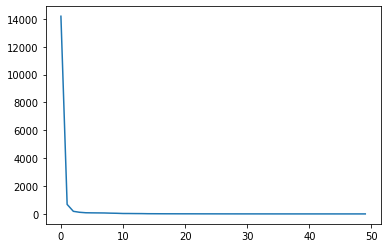

In [26]:
eig_val_sorted_idx = np.flip(np.argsort(eig_val))
pc_values = np.arange(50)
plt.plot(pc_values, eig_val[eig_val_sorted_idx][:50])

### **c) Transform the original count matrix using the top 2 ranked principal component (eigen) vectors from b) and plot the data in the first two components, colored by 'cell_type'.** (8 points)

The 'cell_type' metadata column represents the cell type designation of each cell from the study.

### **d) Plot the same transformed data and color by the total read counts for each cell (counts across all genes). (5 points)**

Directions of variance highlighted by the the principal components can correspond to other non-biological facets of the data, such as which cells had more sequenced UMIs.

Remember that the counts have been previously log transformed (ln). 

### **e) Perform SVD on the centered data matrix, construct a Scree plot from $D,V$, and report the number of components chosen for reduction. Plot the points transformed by the top 2 eigenvectors, colored by 'cell_type'. (10 points)**

Use the [numpy.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) function to find the SVD factorization of the matrix. The Singular Value Decomposition of $X$ provides a factorization of $X$ where $X = U\Sigma V^T$. Here $\Sigma$ is a diagonal matrix containing the singular values of $X$. $U,V$ represent, respectively, the left and right singular vectors corresponding to those values. We will use $\Sigma$ and $V$ as the eigenvalues and (right) eigenvectors, as compared to part a). 

**Plot a Scree plot for the top 50 singular values/vectors and report the number of components you would select to retain. Transform the data matrix using the top 2 components and plot (as in c) the transformed points colored by 'cell_type'.**

In [29]:
u, s, vh = np.linalg.svd(centered)

### **f) Perform PCA with the [sklearn PCA function](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and print the top 2 eigenvectors from the function alongside what you calculated in a) and e) (6 points)**

You can set the number of components for the PCA calculation to be the same size as the dataset, and then select the top 2 components from the result. By default this PCA function will use SVD to approximate the solution.

**Report the top 2 components (vectors) and print the top 2 components from a) and e).**


```
>>> pca = PCA(n_components=2, svd_solver='full')
>>> pca.fit(X)
PCA(n_components=2, svd_solver='full')
>>> print(pca.singular_values_)
[6.30061... 0.54980...]
#Use pca.components_.T to get component vectors
```



In [32]:
pca = PCA(n_components=2, svd_solver="full")
pca.fit(np.asarray(centered))
print(pca.singular_values_)
print(pca.components_.T)

[3658.05214701 2727.58342588]
[[ 0.00251544  0.00456457]
 [ 0.00372582  0.01158779]
 [ 0.01006912 -0.00158479]
 ...
 [ 0.0033924  -0.00063106]
 [ 0.00293415 -0.00784024]
 [-0.0037984  -0.01078764]]


### **g) Transform the count matrix using the top 2 component vectors from part f) and report the top 5 genes for the first and second principal component (eigen) vectors (8 points)**

By looking at the weights/values of each gene in each eigenvector, we can determine which genes have the highest weights for the given vector.

**Report the gene names for the top 5 weighted genes in each of the two eigenvectors.**